# Building deep learning models for classification
You'll use the Keras library to build deep learning models for classification. By the end of the chapter, you'll have all the tools necessary to build deep neural networks.

This demo is a jupyter notebook, i.e. intended to be run step by step.

Author: Eric Einspänner and Nastaran Takmilhomayouni

First version: 6th of July 2023


Copyright 2023 Clinic of Neuroradiology, Magdeburg, Germany

License: Apache-2.0

## Table Of Contents
1. [Intial set-up](#Initial-Set-Up)
2. [Load Data](#Load-Data)
    - [Details](#Details)
    - [The Math](#The-Math)
    - [Data Exploration](#Data-Exploration)
    - [Exercise](#Exercise)
    - [Data Summary](#Data-summary)
3. [Building the model](#Building-the-model)
    - [Verifying the model](#Verifying-the-model)
4. [Initiate Training](#Initiate-Training)
5. [Evaluating the model](#Evaluating-the-model)
    - [Prediction](#Prediction)
6. [Conclusion](#Conclusion)
    - [References](#References)  

## Initial Set-Up

In [1]:
# Make sure figures appears inline and animations works
# Edit this to ""%matplotlib notebook" when using the "classic" jupyter notebook interface
%matplotlib widget

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf

tf.config.list_physical_devices('GPU')

[]

## Load Data

### Details

Speaking of graphics, we're going to tackle a challenge that seemed almost impossible decades ago: image classification with computer vision. Specifically, we will try to classify ... from the Chest MedMNIST dataset. A few samples are shown below. The ChestMNIST is based on the NIH-ChestXray14 dataset [1], a dataset comprising 112,120 frontal-view X-Ray images of 30,805 unique patients with the text-mined 14 disease labels, which could be formulized as a multi-label binary-class classification task. We use the official data split, and resize the source images of 1 × 1,024 × 1,024 into 1 × 28 × 28. 

![alt text](Images/ChestMNIST.jpg "Chest MNIST")

Neural networks attempt to copy the human learning technique, Trial and Error. To do this, we will create something like a set of digital flashcards. Our artificial brains will attempt to guess what kind of clothing we are showing it with a flashcard, then we will give it the answer, helping the computer learn from its successes and mistakes.

Just like how students are quizzed to test their understanding, we will set aside a portion of our data to quiz our neural networks to make sure they understand the concepts we're trying to teach them, as opposed to them memorizing the answers to their study questions. For trivia, memorization might be an acceptable strategy, but for skills, like adding two numbers, memorization won't get our models very far.

The study data is often called the `training dataset` and the quiz data is often called the `validation dataset`.

### The Math

Computers are built with discrete 0s and 1s whereas humans and animals are built on more continuous building blocks. Because of this, some of the first neurons attempted to mimic biological neurons with a linear regression function: `y = mx + b`. The `x` is like information coming in through the dendrites and the `y` is like the output through the terminals. As the computer guesses more and more answers to the questions we present it, it will update its variables (`m` and `b`) to better fit the line to the data it has seen.

Neurons are often exposed to multivariate data. We're going to build a neuron that takes each pixel value (which is between `0` and `255`), and assign it a weight, which is equivalent to our `m`. Data scientists often express this weight as `w`. For example, the first pixel will have a weight of `w0`, the second will have a weight of `w1`, and so on. Our full equation becomes `y = w0x0 + w1x1 + w2x2 + ... + b`.

Each image is 28 pixels by 28 pixels, so we will have a total of 784 weights. A pixel value of `0` would be black and a pixel value of `255` would be white. Let's look at the raw pixel values of the previous image we plotted. Each number below will be assigned a weight.

### Data exploration

In [4]:
# Define the path to dataset
data_path = './Data/ChestMNIST/chestmnist.npz'

# Load the dataset
ds = np.load(data_path)
print('Content of dataset: ', list(ds.keys()))

Content of dataset:  ['train_images', 'val_images', 'test_images', 'train_labels', 'val_labels', 'test_labels']


In [5]:
print('Number of train images: {} and number of labels: {}.'.format(len(ds['train_images']), len(ds['train_labels'])))
print('Number of validation images: {} and number of labels: {}.'.format(len(ds['val_images']), len(ds['val_labels'])))
print('Number of testing images: {} and number of labels: {}.'.format(len(ds['test_images']), len(ds['test_labels'])))

Number of train images: 78468 and number of labels: 78468.
Number of validation images: 11219 and number of labels: 11219.
Number of testing images: 22433 and number of labels: 22433.


Let's start with our `train_images` and `train_labels`. `train_images` are like the question on our flashcards and `train_labels` are like the answer. In general, data scientists often refer to this answer as the label.

We can plot one of these images to see what it looks like. To do so, we will use Matplotlib.

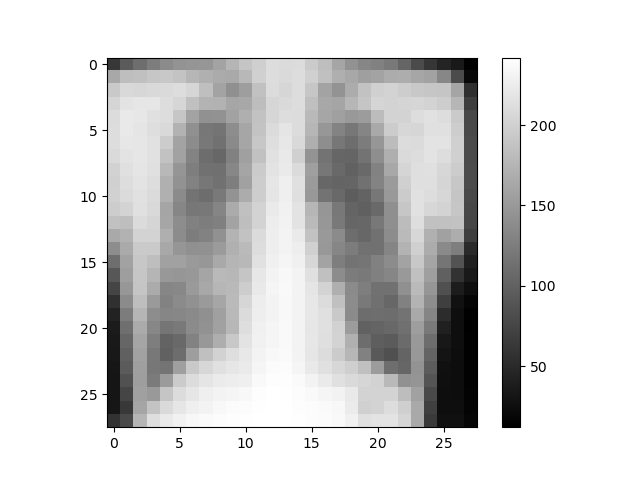

In [6]:
# The question number to study with. Feel free to change up to 78468.
data_idx = 42

plt.figure()
plt.imshow(ds['train_images'][data_idx], cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()

What would you classify this as?

In [7]:
ds['train_labels'][data_idx]

array([1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

You can see that this is mainly a dataset of 112,120 samples and has the following nature:

- Multi-Label: A sample may have multiple different Labels at the same time
- Binary Class: Each label is a binary classification

These categories are:
- 0: atelectasis: Insufficiency of lung inflation
- 1: cardiomegaly: hypertrophy of the heart
- 2: effusion: exudate
- 3: Infiltration: Infiltration
- 4: mass: a lump
- 5: nodule: nodules
- 6: pneumonia: pneumonia
- 7: Pneumothorax: pneumothorax
- 8: consolidation: (lung) real changes
- 9: EDEMA: pulmonary edema
- 10: Emphysema: emphysema
- 11: fibrosis: fibrosis
- 12: pleural thickening: pleural thickening
- 13: Hernia: Hernia

We would now like to know how the data is divided between the individual cases. Patients without a specific diagnosis are considered healthy.

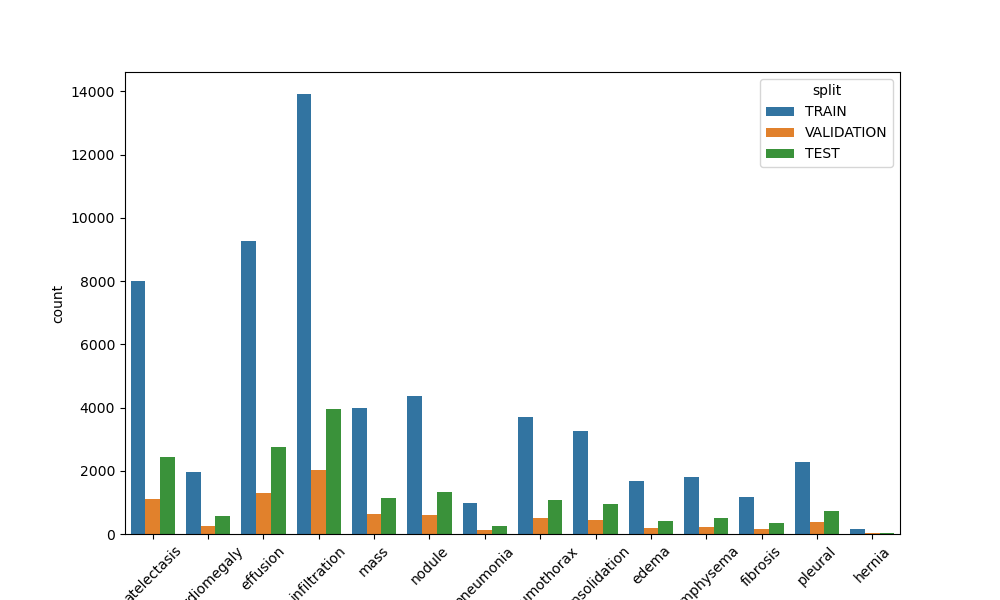

In [8]:
# Read the CSV file into a DataFrame
df = pd.read_csv('./Data/ChestMNIST/dataset.csv')

# Reshape the DataFrame using melt
df_long = df.melt(id_vars=['split', 'img'])

# Filter out rows with value = 0
df_long = df_long[df_long['value'] != 0]

# Create the bar plot using seaborn
plt.figure(figsize=(10, 6))
sns.countplot(x='variable', hue='split', data=df_long)
plt.xticks(rotation=45)
plt.show()

### Exercise
Your task in this exercise is to plot one sample (e.g. 89) and the correspondig label of the validation data.

In [9]:
# Write your code here (the solution is below)








[0 0 0 0 1 0 0 0 0 0 0 0 0 0]


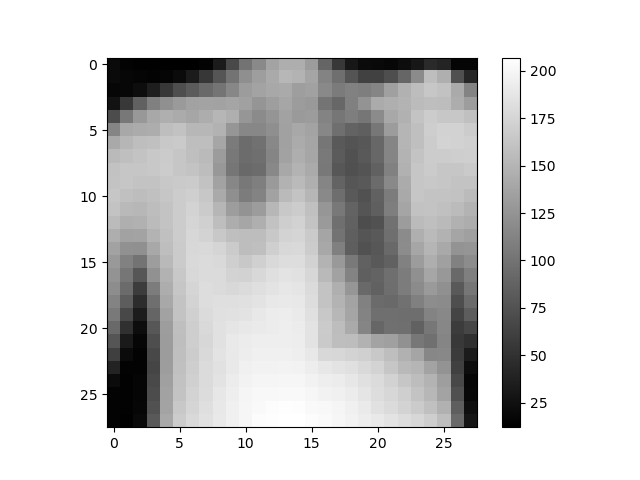

In [10]:
### Solution
# The question number to quiz with. Feel free to change up to 11219.
data_idx = 89

print(ds['val_labels'][data_idx])

plt.figure()
plt.imshow(ds['val_images'][data_idx], cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()

### Data summary
According to the introduction of our data a few days ago, we can know that ChestMNIST is a dataset with the following characteristics:

- Each data point is a chest X-ray image
- The resolution of each image is 28x28
- Since it is grayscale, the channel of the image is 1 (compared to 3 for common RGB)
- The Outcome part predicts whether there are 14 different symptoms (and there may be several) in the image

## Building the model
In the below model, we have two layers:
* [Flatten](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Flatten) - Converts multidimensional data into 1 dimensional data (ex: a list of lists into a single list).
* [Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense) -  A "row" of neurons. Each neuron has a weight (`w`) for each input. In the example below, we use the number `10` to place ten neurons.

We will also define an `input_shape` which is the dimensions of our data. In this case, our `28x28` pixels for each image.

In [11]:
number_of_classes = len(ds['train_labels'][0])
number_of_classes

14

In [12]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(784, input_shape=(28,28), activation='relu'))
model.add(tf.keras.layers.Dense(number_of_classes, activation='sigmoid'))
model.build()

In [13]:
from keras.models import Sequential
from keras.layers import Dense, Flatten

# Create a Sequential model
model = Sequential()

# Add layers
model.add(Flatten(input_shape=(28, 28)))  # Flatten the input data
model.add(Dense(128, activation='relu'))   # Fully connected layer with ReLU activation
model.add(Dense(64, activation='relu'))    # Fully connected layer with ReLU activation
model.add(Dense(number_of_classes, activation='sigmoid')) # Output layer with sigmoid activation for multi-label classification

### Verifying the model

To make sure our model has the structure we expect, we can call the [summary](https://www.tensorflow.org/js/guide/models_and_layers#model_summary) method.

In [14]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               100480    
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 14)                910       
                                                                 
Total params: 109,646
Trainable params: 109,646
Non-trainable params: 0
_________________________________________________________________


We can see that our total parameter count is ???.

There are a few other ways to verify our model. We can also [plot](https://keras.io/api/utils/model_plotting_utils/) it:

In [15]:
tf.keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


## Initiate Training

We have a model setup, but how does it learn? Just like how students are scored when they take a test, we need to give the model a function to grade its performance. Such a function is called the `loss` function.

In this case, we're going to use a type of function specific to classification called [SparseCategoricalCrossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy):
* **Sparse** - for this function, it refers to how our label is an integer index for our categories
* **Categorical** - this function was made for classification
* **Cross-entropy** - the more confident our model is when it makes an incorrect guess, the worse its score will be. If a model is 100% confident when it is wrong, it will have a score of negative infinity!
* `from_logits` - the linear output will be transformed into a probability which can be interpreted as the model's confidence that a particular category is the correct one for the given input.

This type of loss function works well for our case because it grades each of the neurons simultaneously. If all of our neurons give a strong signal that they're the correct label, we need a way to tell them that they can't all be right.

For us humans, we can add additional `metrics` to monitor how well our model is learning. For instance, maybe the loss is low, but what if the `accuracy` is not high?

In [16]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Evaluating the model

Now the moment of truth! The below [fit](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit) method will both help our model study and quiz it.

An `epoch` is one review of the training dataset. Just like how school students might need to review a flashcard multiple times before the concept "clicks", the same is true of our models.

After each `epoch`, the model is quizzed with the validation data. Let's watch it work hard and improve:

In [17]:
ds['train_images'].shape, ds['train_labels'].shape


((78468, 28, 28), (78468, 14))

In [18]:
history = model.fit(
    ds['train_images'],
    ds['train_labels'],
    epochs=5,
    batch_size=32,
    verbose=True,
    validation_data=(ds['val_images'], ds['val_images'])
)

Epoch 1/5
2440/2453 [============================>.] - ETA: 0s - loss: 0.3572 - accuracy: 0.1365

ValueError: in user code:

    File "C:\Users\nasta\anaconda3\lib\site-packages\keras\engine\training.py", line 1727, in test_function  *
        return step_function(self, iterator)
    File "C:\Users\nasta\anaconda3\lib\site-packages\keras\engine\training.py", line 1713, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\nasta\anaconda3\lib\site-packages\keras\engine\training.py", line 1701, in run_step  **
        outputs = model.test_step(data)
    File "C:\Users\nasta\anaconda3\lib\site-packages\keras\engine\training.py", line 1667, in test_step
        self.compute_loss(x, y, y_pred, sample_weight)
    File "C:\Users\nasta\anaconda3\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "C:\Users\nasta\anaconda3\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "C:\Users\nasta\anaconda3\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "C:\Users\nasta\anaconda3\lib\site-packages\keras\losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "C:\Users\nasta\anaconda3\lib\site-packages\keras\losses.py", line 2162, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "C:\Users\nasta\anaconda3\lib\site-packages\keras\backend.py", line 5677, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((None, 14) vs (None, 28, 28)).


In [19]:
history_acc = history.history['accuracy']
history_val_acc = history.history['val_accuracy']
history_loss = history.history['loss']
history_val_loss = history.history['val_loss']

NameError: name 'history' is not defined

In [ ]:
def plot_acc_loss(history):
    plt.figure(figsize=(20, 6))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.legend()

plot_acc_loss(history)

### Prediction

Time to graduate our model and let it enter the real world. We can use the [predict](https://www.tensorflow.org/api_docs/python/tf/keras/Model#predict) method to see the output of our model on a set of images, regardless of if they were in the original datasets or not.

Please note, Keras expects a batch, or multiple datapoints, when making a prediction. To make a prediction on a single point of data, it should be converted to a batch of one datapoint.

Below are the predictions for the items in our `test dataset`.

In [ ]:
model.predict(ds['test_images'])

These are raw results and need some formatting to be interpreted by the average human, so below, we've displayed an image to be classified as well as graph the results of each of our output neurons. The larger the value, the more confident the neuron is that it corresponds to the correct label (and the more negative it is, the more confident it is that it is not the correct label).

In [ ]:
data_idx = 8675 # The question number to study with. Feel free to change up to 22432.

plt.figure()
plt.imshow(ds['test_images'][data_idx], cmap='gray')
plt.colorbar()
plt.grid(False)
plt.show()

x_values = range(number_of_classes)
plt.figure()
plt.bar(x_values, model.predict(ds['test_images'][data_idx:data_idx+1]).flatten())
plt.xticks(len(number_of_classes))
plt.show()

print("correct answer:", ds['test_labels'][data_idx])

# Conclusion

Congratulations on completing the notebook! While this model does significantly better than random guessing, it has a way to go before it can beat humans.

### References
<a id="1">[1]</a>
Wang, X. et al. (2017)
Chestx-ray8: Hospital-scale chest x-ray database and benchmarks on weakly-supervised classification and localization of common thorax diseases.
In Conference on Computer Vision and Pattern Recognition, 3462–3471